Detected sample rate Fs = 1.0 Hz

mean: 23.782
std dev: 0.007
elapsed: 0.019h
min: 23.770
max: 23.795

mean: 54.483
std dev: 0.018
elapsed: 0.374h
min: 54.471
max: 54.768

mean: 60.157
std dev: 0.039
elapsed: 0.374h
min: 59.804
max: 60.166

mean: 72.470
std dev: 0.018
elapsed: 0.375h
min: 72.460
max: 72.751

mean: 90.303
std dev: 0.045
elapsed: 0.374h
min: 90.256
max: 90.784

mean: 95.265
std dev: 0.057
elapsed: 0.374h
min: 95.245
max: 95.846

mean: 24.607
std dev: 0.012
elapsed: 0.064h
min: 24.591
max: 24.705



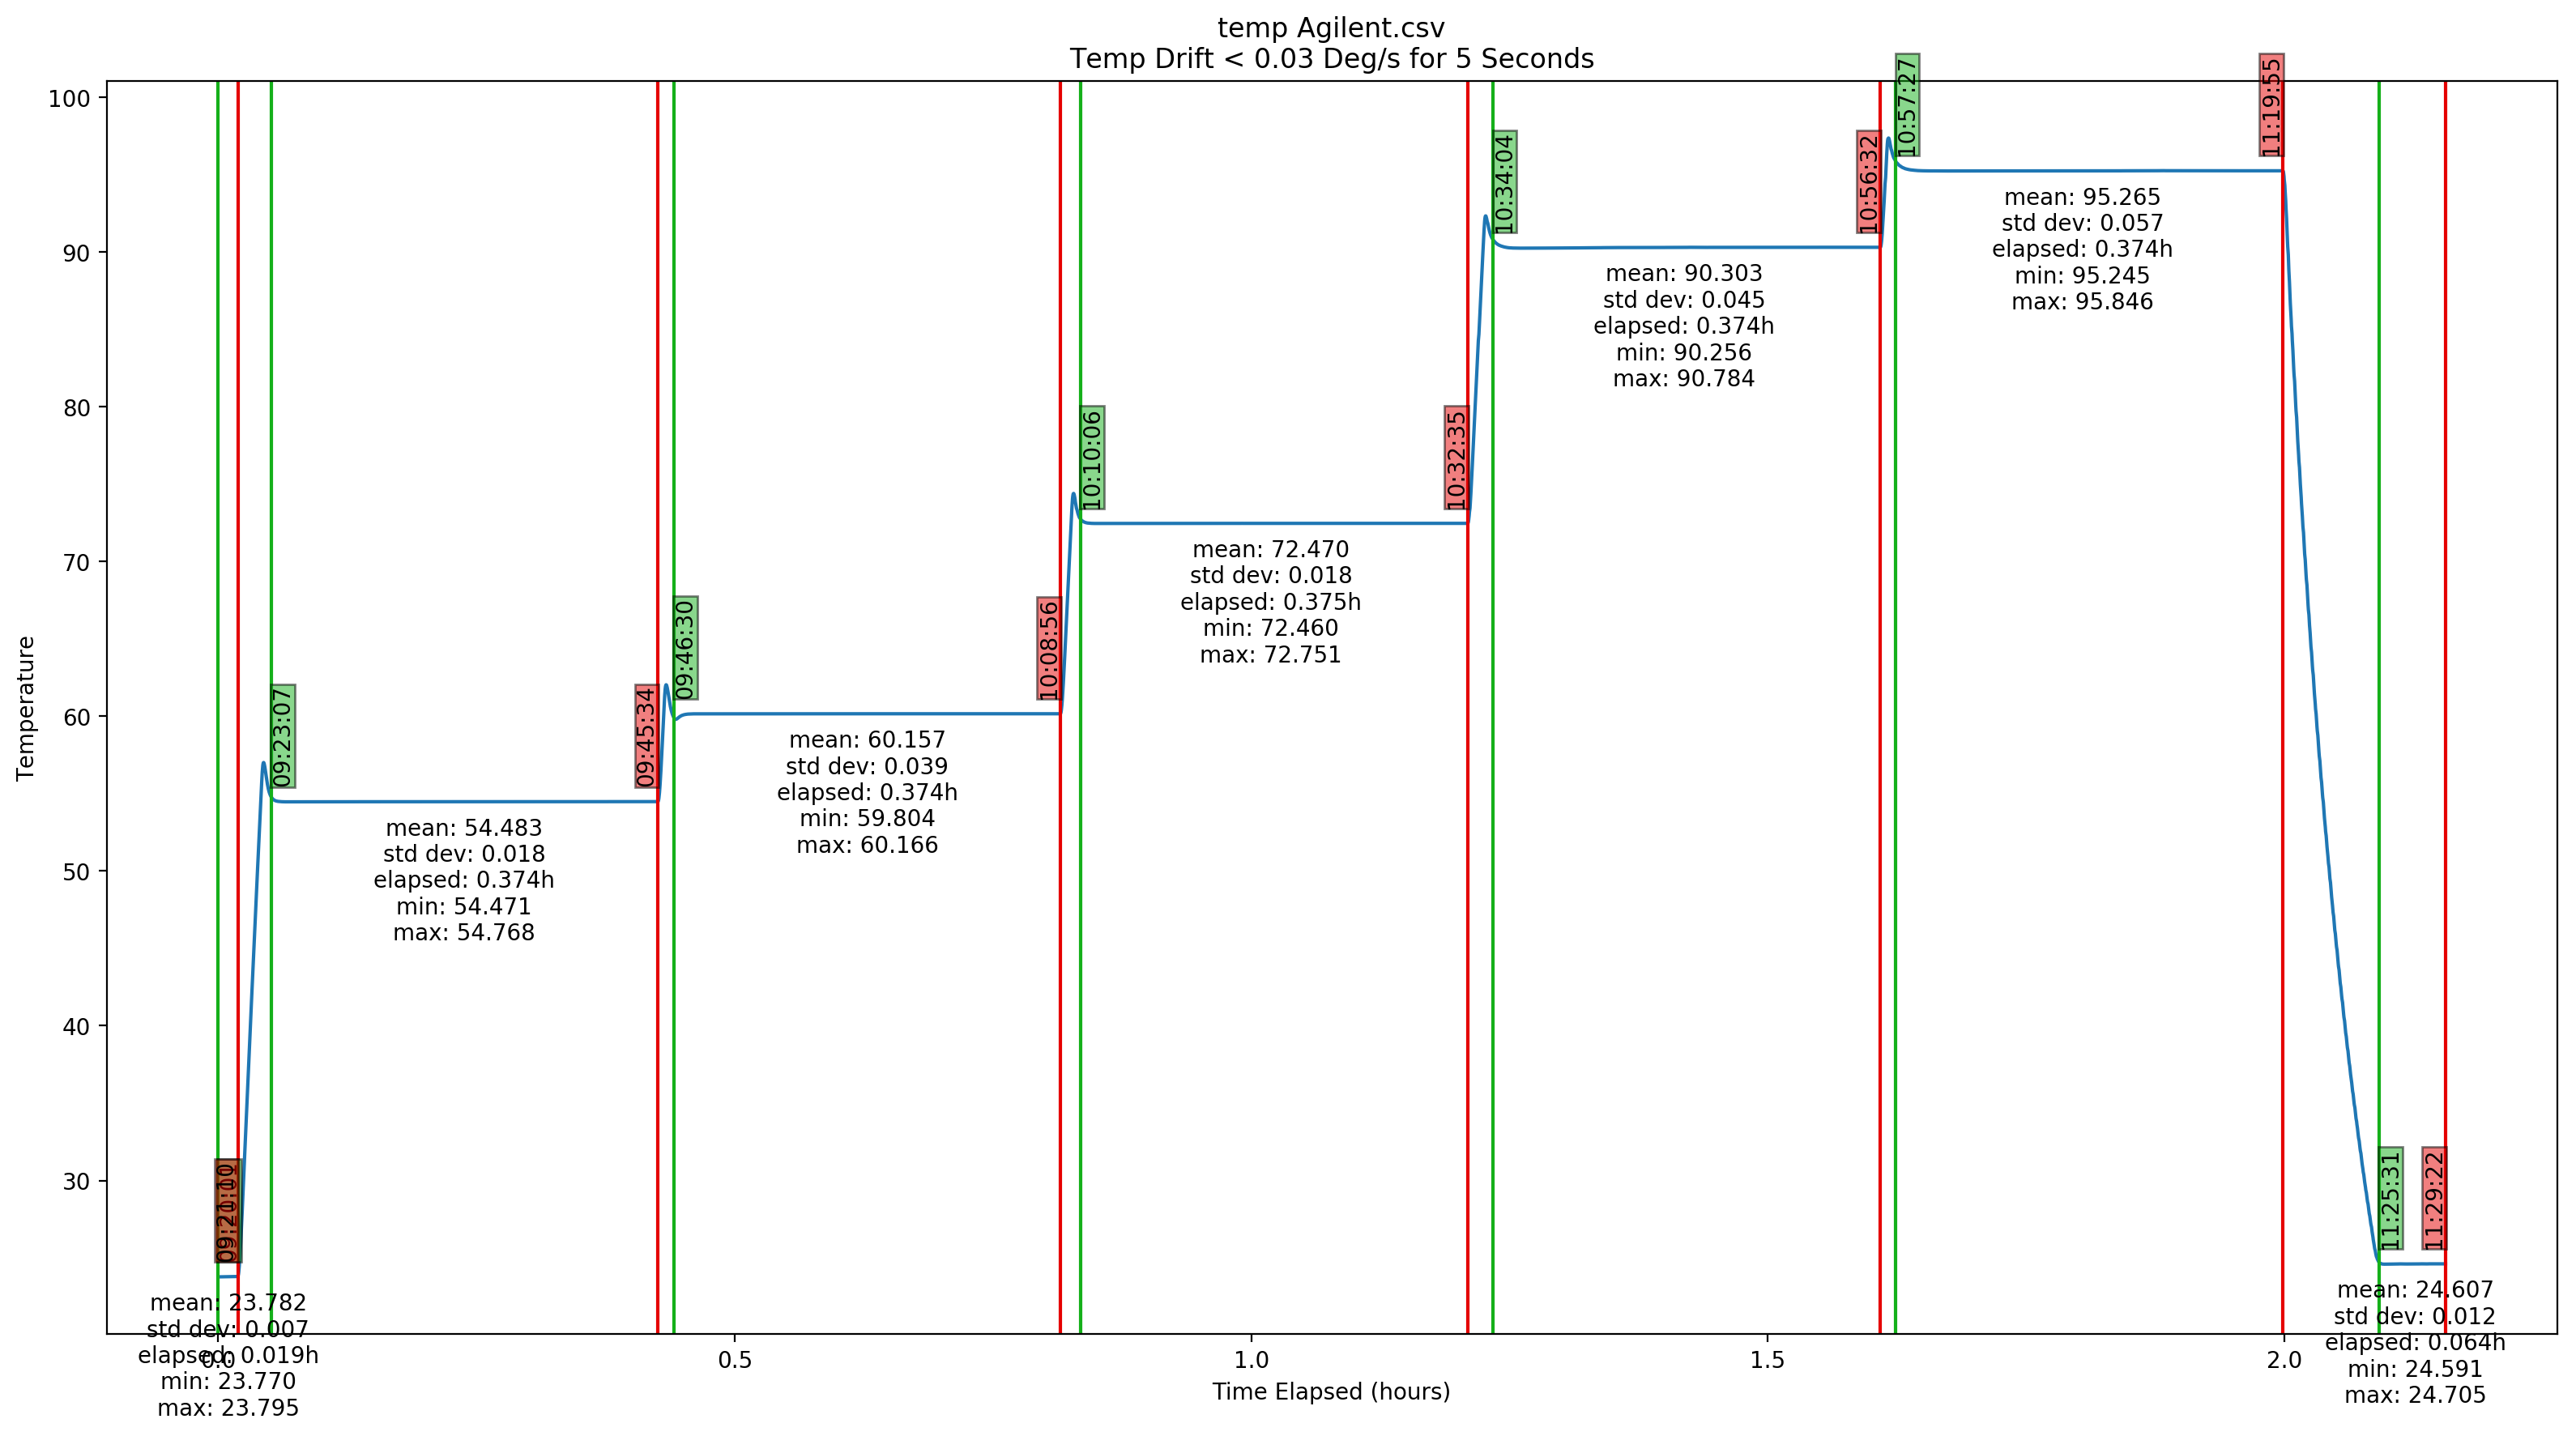

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt

MAX_DELTA_T = 0.03  # Max temperature change in deg C / second to be considered part of plateau
STABLE_TIME = 5  # Minimum number of seconds
FILE_NAME = 'temp Agilent.csv'


# https://stackoverflow.com/questions/4494404/find-large-number-of-consecutive-values-fulfilling-condition-in-a-numpy-array
def contiguous_regions(condition):
    """Finds contiguous True regions of the boolean array "condition". Returns
    a 2D array where the first column is the start index of the region and the
    second column is the end index."""

    # Find the indicies of changes in "condition"
    d = np.diff(condition)
    idx, = d.nonzero()

    # We need to start things after the change in "condition". Therefore,
    # we'll shift the index by 1 to the right.
    idx += 1

    if condition[0]:
        # If the start of condition is True prepend a 0
        idx = np.r_[0, idx]

    if condition[-1]:
        # If the end of condition is True, append the length of the array
        idx = np.r_[idx, condition.size - 1]  # Edit

    # Reshape the result into two columns
    idx.shape = (-1, 2)
    return idx


# Load CSV file and label columns
dataframe = pd.read_csv(FILE_NAME, names=['temperature', 'time'], index_col=False, parse_dates=['time'], usecols=[0, 1])

# Detect sample rate of data
sample_rate = 1 / (dataframe.time[1] - dataframe.time[0]).total_seconds()
print('Detected sample rate Fs = {} Hz'.format(sample_rate))
print()

# Calculate magnitude of temperature derivative (i.e. temperature change/second)
dataframe['derivative'] = np.abs(np.gradient(dataframe.temperature))

# Low pass the temperature data with a window function STABLE_COUNT seconds wide
filter_width = int(STABLE_TIME * sample_rate)
dataframe['derivative'] = filtfilt([1 / filter_width] * filter_width, [1], dataframe['derivative'])

# Generate timestamps as seconds from start
dataframe['hours'] = (dataframe.time - dataframe.time[0]) / np.timedelta64(1, 'h')

# Plot the temperature data
plt.figure(figsize=(16, 9), dpi=200)
plt.title('{}\nTemp Drift < {} Deg/s for {} Seconds'.format(FILE_NAME, MAX_DELTA_T, STABLE_TIME))
plt.plot(dataframe.hours, dataframe.temperature)
plt.xlabel('Time Elapsed (hours)')
plt.ylabel('Temperature')

# Find the start and end of each plateau and plot them
for start, end in contiguous_regions((dataframe['derivative'] < MAX_DELTA_T).to_numpy()):
    start_time = dataframe.hours[start]
    end_time = dataframe.hours[end]

    plateau = dataframe['temperature'][start:end]
    mean = np.mean(plateau)
    stdev = np.std(plateau)
    elapsed = end_time - start_time

    # Start in green
    plt.axvline(x=start_time, color='xkcd:green')
    plt.text(x=start_time, y=mean + 1, s=dataframe['time'][start].strftime('%H:%M:%S'), rotation=90,
             verticalalignment='bottom', bbox=dict(facecolor='xkcd:green', alpha=0.5, pad=0.3))

    # End in red
    plt.axvline(x=end_time, color='xkcd:red')
    plt.text(x=end_time, y=mean + 1, s=dataframe['time'][end].strftime('%H:%M:%S'), rotation=90,
             verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='xkcd:red', alpha=0.5, pad=0.3))

    label = 'mean: {:.3f}\nstd dev: {:.3f}\nelapsed: {:.3f}h\nmin: {:.3f}\nmax: {:.3f}'.format(mean, stdev, elapsed,
                                                                                              min(plateau),
                                                                                              max(plateau))

    # Add label and print results
    plt.text(x=dataframe.hours[int(np.mean([start, end]))], y=mean - 1, s=label, horizontalalignment='center',
             verticalalignment='top')
    print(label)
    print()

plt.tight_layout()
plt.show()
